Import Data

In [1357]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [1358]:
# import excel file
df = pd.read_csv('jabodetabek_house_price.csv')

Data Cleaning

In [1359]:
# List of columns to drop
cols_to_drop = [
    'url', 'title', 'address', 'lat', 'long', 'facilities',
    'property_type', 'ads_id', 'certificate', 'electricity',
    'building_age', 'year_built', 'property_condition',
    'building_orientation', 'furnishing', 'carports',
    'maid_bedrooms', 'maid_bathrooms'
]

# Rename column name
df_cleaned = df.drop(columns=cols_to_drop).rename(columns={
    'price_in_rp': 'harga',
    'district': 'distrik',
    'city': 'kota',
    'bedrooms': 'kamar',
    'bathrooms': 'kamar_mandi',
    'land_size_m2': 'area(m²)',
    'building_size_m2': 'size(m²)',
    'floors': 'lantai',
    'garages': 'garasi'
})

df_cleaned.head()

,harga,distrik,kota,kamar,kamar_mandi,area(m²),size(m²),lantai,garasi
0,2.990000e+09,Summarecon Bekasi,Bekasi,4.0,4.0,239.0,272.0,2.0,0
1,1.270000e+09,Summarecon Bekasi,Bekasi,3.0,2.0,55.0,69.0,2.0,0
2,1.950000e+09,Summarecon Bekasi,Bekasi,3.0,3.0,119.0,131.0,2.0,1
3,3.300000e+09,Summarecon Bekasi,Bekasi,3.0,3.0,180.0,174.0,2.0,2
4,4.500000e+09,Summarecon Bekasi,Bekasi,4.0,3.0,328.0,196.0,2.0,1


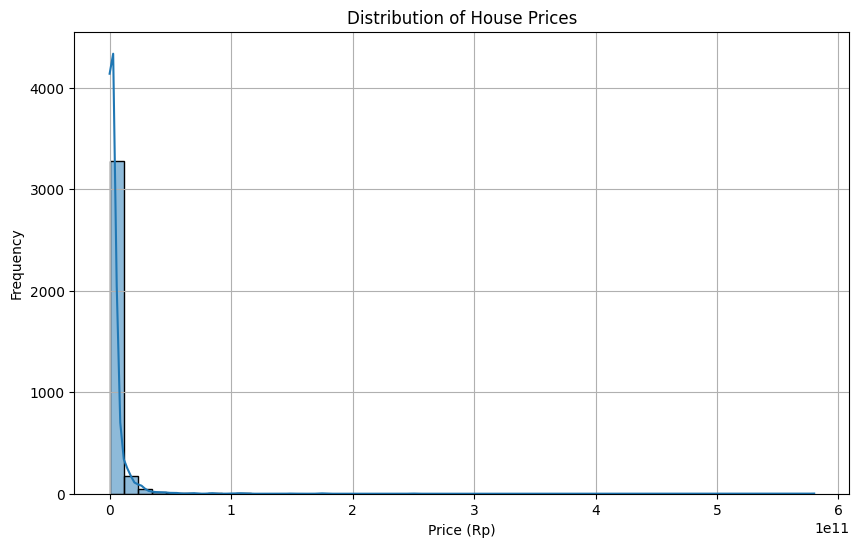

In [1360]:
# Check distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['harga'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price (Rp)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

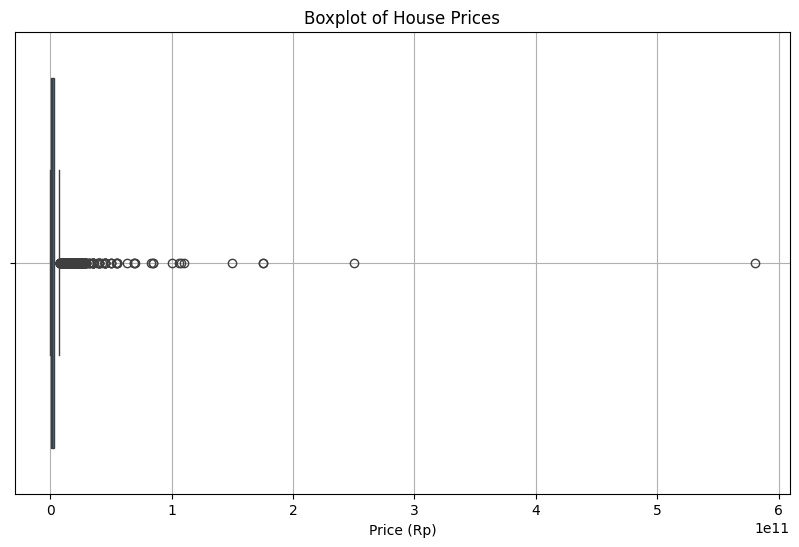

In [1361]:

# Check for outliers in the target variable using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['harga'])
plt.title('Boxplot of House Prices')
plt.xlabel('Price (Rp)')
plt.grid(True)
plt.show()

In [1362]:
# Check for missing values
print(df_cleaned.isnull().sum())

harga           0
distrik         0
kota            0
kamar          34
kamar_mandi    29
area(m²)        2
size(m²)        2
lantai          6
garasi          0
dtype: int64


In [1363]:
# Fill missing value with median
df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# Verify no more missing values
print(df_cleaned.isnull().sum())

harga          0
distrik        0
kota           0
kamar          0
kamar_mandi    0
area(m²)       0
size(m²)       0
lantai         0
garasi         0
dtype: int64


Train-Test Split

In [1364]:
# Apply log transformation to the target variable
df_cleaned['harga_log'] = np.log1p(df_cleaned['harga'])

# Define features (X) and target (y)
X = df_cleaned.drop(columns=['harga', 'harga_log'])
y = df_cleaned['harga_log']

# Perform one-hot encoding for 'distrik' and 'kota' columns
X = pd.get_dummies(X, columns=['distrik', 'kota'], drop_first=True)
feature_columns = X.columns.tolist()

In [1365]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the splits
print(X.shape, X_train.shape, X_test.shape)

(3553, 393) (2842, 393) (711, 393)


In [1366]:
# Normalize data with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1367]:
# Initialize XGBoost model with regularization to reduce overfitting
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

C:\Users\Rafel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Evaluation

In [1368]:
# Predictions on training data
train_predictions_log = model.predict(X_train_scaled)

# Metrics for training data
train_r2 = metrics.r2_score(y_train, train_predictions_log)
train_mae = metrics.mean_absolute_error(y_train, train_predictions_log)
train_mse = mean_squared_error(y_train, train_predictions_log)
train_rmse = np.sqrt(train_mse)

print("Training Data Metrics")
print(f"R Squared Error: {train_r2:.3f}")
print(f"Mean Absolute Error: {train_mae:.3f}")
print(f"Mean Squared Error: {train_mse:.3f}")
print(f"Root Mean Squared Error: {train_rmse:.3f}")

Training Data Metrics
R Squared Error: 0.949
Mean Absolute Error: 0.184
Mean Squared Error: 0.065
Root Mean Squared Error: 0.255


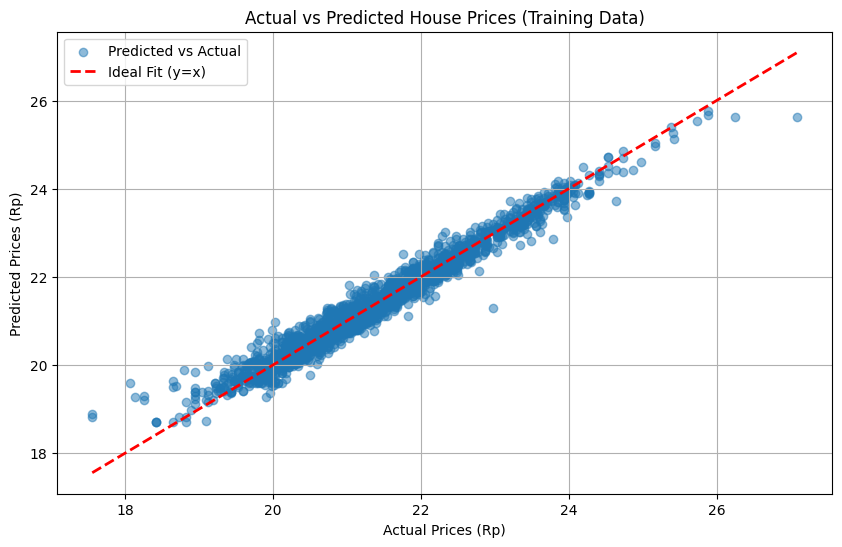

In [1369]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_train), max(y_train)],
         [min(y_train), max(y_train)],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit (y=x)")  # 45-degree line
plt.xlabel("Actual Prices (Rp)")
plt.ylabel("Predicted Prices (Rp)")
plt.title("Actual vs Predicted House Prices (Training Data)")
plt.grid(True)
plt.legend()
plt.show()

In [1370]:
# Predictions on test data
test_predictions_log = model.predict(X_test_scaled)

# Metrics for test data
test_r2 = metrics.r2_score(y_test, test_predictions_log)
test_mae = metrics.mean_absolute_error(y_test, test_predictions_log)
test_mse = mean_squared_error(y_test, test_predictions_log)
test_rmse = np.sqrt(test_mse)

print("Test Data Metrics")
print(f"R Squared Error: {test_r2:.3f}")
print(f"Mean Absolute Error: {test_mae:.3f}")
print(f"Mean Squared Error: {test_mse:.3f}")
print(f"Root Mean Squared Error: {test_rmse:.3f}")

Test Data Metrics
R Squared Error: 0.904
Mean Absolute Error: 0.233
Mean Squared Error: 0.120
Root Mean Squared Error: 0.346


In [1371]:
# Convert predictions back to original scale
test_predictions_original = np.expm1(test_predictions_log)
y_test_original = np.expm1(y_test)

# Calculate in the original scale
test_mae_original = metrics.mean_absolute_error(y_test_original, test_predictions_original)
test_mse_original = mean_squared_error(y_test_original, test_predictions_original)
test_rmse_original = np.sqrt(test_mse_original)

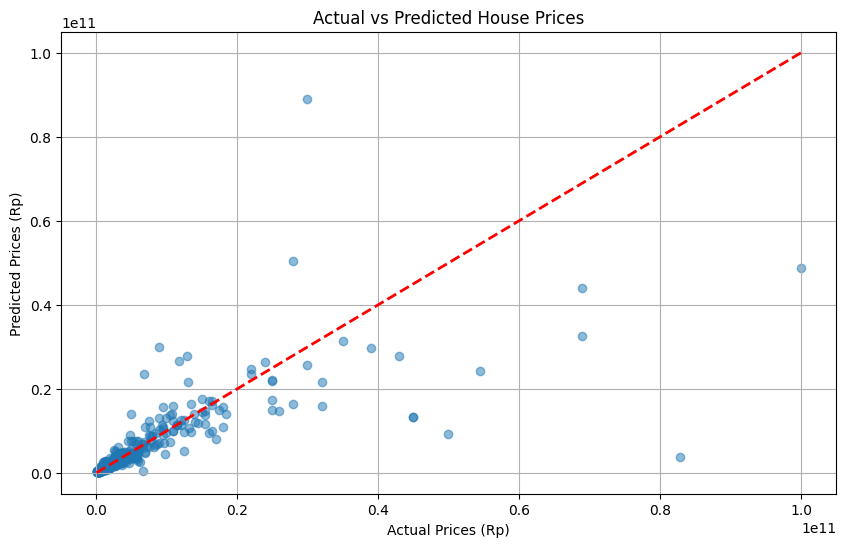

In [1372]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, test_predictions_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='red', linestyle='--', linewidth=2)  # 45-degree line
plt.xlabel("Actual Prices (Rp)")
plt.ylabel("Predicted Prices (Rp)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


Plot

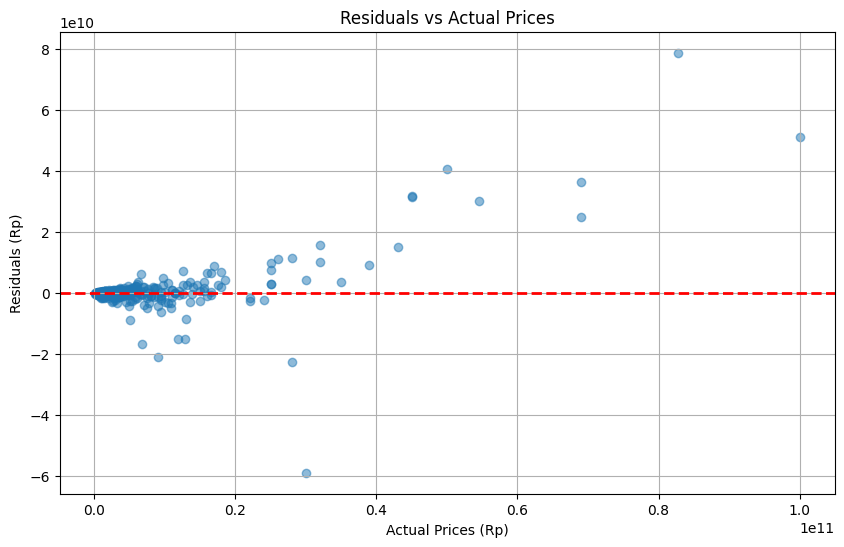

In [1373]:
# Calculate residuals
residuals = y_test_original - test_predictions_original

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Prices (Rp)")
plt.ylabel("Residuals (Rp)")
plt.title("Residuals vs Actual Prices")
plt.grid(True)
plt.show()

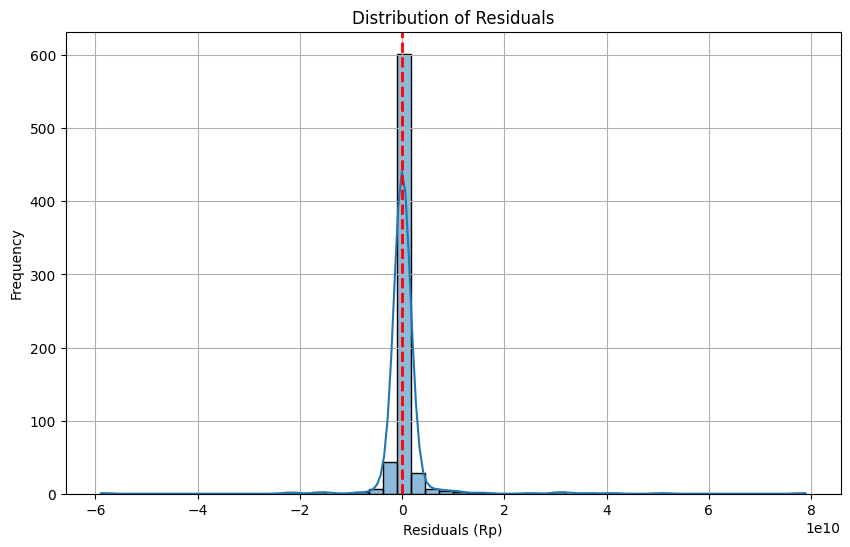

In [1374]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Residuals (Rp)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

In [1375]:
# Performance Metrics Summary
print("Performance Metrics Summary:")
print(f"R Squared Error (Log Scale): {test_r2:.3f}")
print(f"Mean Absolute Error (Log Scale): {test_mae:.3f}")
print(f"Mean Squared Error (Log Scale): {test_mse:.3f}")
print(f"Root Mean Squared Error (Log Scale): {test_rmse:.3f}")
print(f"Mean Absolute Error (Original Scale): {test_mae_original:.3f}")
print(f"Mean Squared Error (Original Scale): {test_mse_original:.3f}")
print(f"Root Mean Squared Error (Original Scale): {test_rmse_original:.3f}")

Performance Metrics Summary:
R Squared Error (Log Scale): 0.904
Mean Absolute Error (Log Scale): 0.233
Mean Squared Error (Log Scale): 0.120
Root Mean Squared Error (Log Scale): 0.346
Mean Absolute Error (Original Scale): 1398080073.429
Mean Squared Error (Original Scale): 31988761575572877312.000
Root Mean Squared Error (Original Scale): 5655860816.496


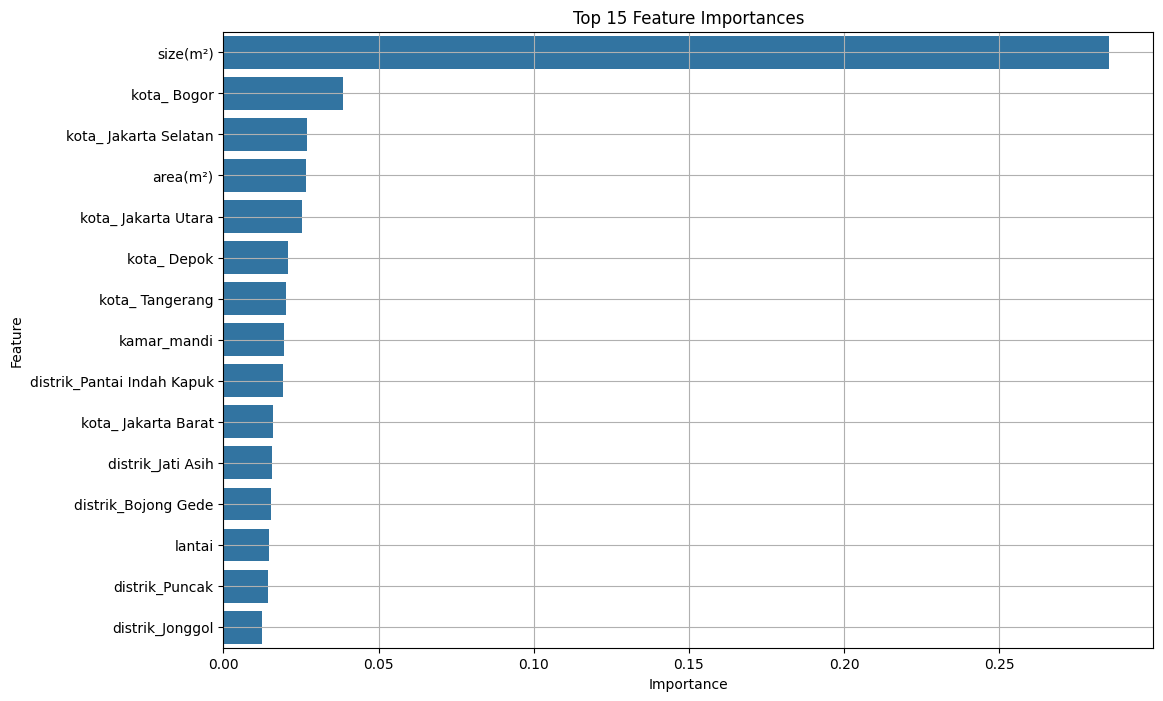

In [1376]:
importances = model.feature_importances_
feature_names = feature_columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.grid(True)
plt.show()


In [1377]:
with open('XGBoost.pkl', 'wb') as file:
    pickle.dump(model, file)

with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)
    
with open("feature_columns.pkl", "wb") as file:
    pickle.dump(feature_columns, file)